# 1. Neural Decision Variables Extraction

## 1.1 Project Context
This notebook implements the decision variables extraction methodology for the ClickDV project - a computational neuroscience analysis linking Poisson click input data from rats to decision variable outputs. This analysis is part of the Brody-Daw lab rotation work.

## 1.2 Objective
Extract decision variables (DVs) from neural spike data using logistic regression to decode choice from population firing rates. The methodology follows the approach described in "Brain-wide coordination of decision formation and commitment" (Bondy et al., 2025 Draft).

### 1.2.1 What are Decision Variables?

- **Definition**: 1-dimensional time series DV(t,i) representing neural population "confidence" in making a particular choice on trial i at time t
- **Interpretation**: Positive values indicate evidence for one choice (e.g., rightward), negative values for the alternative choice (e.g., leftward)
- **Units**: Log-odds of choice probability, equivalent to log(p_right / p_left)
- **Purpose**: Dimensionality reduction of hundreds of neurons into single time-varying decision signal

### 1.2.2 Key Methodology Features

- Logistic regression with L1 regularization
- 10-fold stratified cross-validation
- Geometric mean regularization approach for temporal consistency
- 50ms Gaussian smoothing of firing rates
- Trial-by-trial resolution capturing decision formation dynamics

## 1.3 Setup and Dependencies

### 1.3.1 Import Required Libraries

In [354]:
# Core scientific computing
import numpy as np
import scipy as sp
from scipy import ndimage
from scipy.io import loadmat
import pandas as pd
import json

# Machine learning
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.exceptions import ConvergenceWarning


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
from tqdm import tqdm
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any


# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11
})

# Suppress sklearn warnings
warnings.filterwarnings('ignore', category=UserWarning)

print("Libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"SciPy version: {sp.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Libraries imported successfully
NumPy version: 2.3.2
SciPy version: 1.16.1
Matplotlib version: 3.10.5
Seaborn version: 0.13.2


### 1.3.2 Set Reproducibility Parameters

In [355]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Analysis parameters (from paper methodology)
GAUSSIAN_SIGMA_MS = 50  # Gaussian smoothing kernel standard deviation (ms)
SAMPLING_INTERVAL_MS = 50  # Time bin size (ms)
TIME_WINDOW = (-0.025, 1)  # Analysis window relative to stimulus onset (seconds)
CV_FOLDS = 10  # Number of cross-validation folds

# Session quality control criteria (from Methods, page 30)
MIN_TRIALS = 300  # Minimum trials required for session inclusion
MAX_LAPSE_RATE = 0.08  # Maximum allowed lapse rate (8%)

# Nan threshold for dealing with few trials:
NAN_THRESHOLD = 5 * CV_FOLDS  # Minimum trials per condition to avoid NaNs

print(f"Random seed set to: {RANDOM_SEED}")
print(f"Gaussian smoothing: {GAUSSIAN_SIGMA_MS}ms standard deviation")
print(f"Sampling interval: {SAMPLING_INTERVAL_MS}ms")
print(f"Analysis window: {TIME_WINDOW[0]}s to {TIME_WINDOW[1]}s")
print(f"Cross-validation: {CV_FOLDS} folds")
print(f"Quality control: ≥{MIN_TRIALS} trials, ≤{MAX_LAPSE_RATE*100}% lapse rate")

Random seed set to: 42
Gaussian smoothing: 50ms standard deviation
Sampling interval: 50ms
Analysis window: -0.025s to 1s
Cross-validation: 10 folds
Quality control: ≥300 trials, ≤8.0% lapse rate


### 1.3.3 Define File Paths and Session Parameters

In [356]:
# Data paths
PROJECT_ROOT = Path('/home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV')
SESSION_ID = 'A324'
SESSION_DATE = '2023-07-27'
DATA_DIR = PROJECT_ROOT / 'data' / 'raw' / SESSION_ID / SESSION_DATE
OUTPUT_DIR = PROJECT_ROOT / 'data' / 'processed'
MATLAB_CONVERSION = True  # Whether data was converted from MATLAB

# Session-specific parameters
DATA_FILE = DATA_DIR / f'{SESSION_ID}_pycells_{SESSION_DATE.replace("-", "")}.mat'

# Create output directory if it doesn't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Verify data file exists
if not DATA_FILE.exists():
    raise FileNotFoundError(f"Data file not found: {DATA_FILE}")

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Session: {SESSION_ID} ({SESSION_DATE})")
print(f"Data file: {DATA_FILE}")
print(f"Data file exists: {DATA_FILE.exists()}")
print(f"Data file size: {DATA_FILE.stat().st_size / 1024 / 1024:.1f} MB" if DATA_FILE.exists() else "N/A")

Project root: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV
Data directory: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/raw/A324/2023-07-27
Output directory: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/processed
Session: A324 (2023-07-27)
Data file: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/raw/A324/2023-07-27/A324_pycells_20230727.mat
Data file exists: True
Data file size: 942.7 MB


### 1.3.4 Define Core Analysis Functions

These function signatures will be implemented in subsequent sections of the notebook.

In [357]:
# Function signatures for the complete pipeline
# These will be implemented in subsequent notebook sections

def calculate_firing_rates(spike_times: Dict[str, np.ndarray], 
                          trial_times: np.ndarray, 
                          time_bins: np.ndarray, 
                          sigma_ms: float = GAUSSIAN_SIGMA_MS) -> np.ndarray:
    """
    Calculate smoothed firing rates using Gaussian convolution.
    
    Parameters:
    - spike_times: Dict of {neuron_id: spike_times_array}
    - trial_times: Array of trial start times
    - time_bins: Time points relative to trial start
    - sigma_ms: Gaussian kernel standard deviation (ms)
    
    Returns:
    - firing_rates: Array of shape (n_neurons, n_timepoints, n_trials)
    """
    pass  # Implementation in Section 3

def apply_quality_filters(spike_times: Dict[str, np.ndarray], 
                         quality_metrics: Dict[str, Dict]) -> Dict[str, np.ndarray]:
    """
    Apply neuron quality filters based on waveform characteristics.
    
    Parameters:
    - spike_times: Dict of {neuron_id: spike_times_array}
    - quality_metrics: Dict of quality metrics for each neuron
    
    Returns:
    - filtered_spike_times: Dict with only high-quality neurons
    """
    pass  # Implementation in Section 3

def validate_session_quality(choices: np.ndarray, 
                           n_trials: int, 
                           lapse_rate: Optional[float] = None) -> Tuple[bool, str]:
    """
    Validate session meets quality criteria from paper.
    
    Parameters:
    - choices: Array of behavioral choices
    - n_trials: Number of trials
    - lapse_rate: Session lapse rate (optional)
    
    Returns:
    - (passes_qc, reason): Boolean and descriptive string
    """
    pass  # Implementation in Section 4

def find_optimal_regularization(X: np.ndarray, 
                               choices: np.ndarray) -> Tuple[float, List[float]]:
    """
    Find optimal regularization using geometric mean approach.
    
    Parameters:
    - X: Neural data (n_neurons, n_timepoints, n_trials)
    - choices: Binary choices (n_trials,)
    
    Returns:
    - (final_C, individual_lambdas): Optimal regularization parameter and individual values
    """
    pass  # Implementation in Section 5

def calculate_decision_variables(X: np.ndarray, 
                               choices: np.ndarray, 
                               final_C: float) -> Tuple[np.ndarray, List, np.ndarray]:
    """
    Calculate decision variables using logistic regression.
    
    Parameters:
    - X: Neural data (n_neurons, n_timepoints, n_trials)
    - choices: Binary choices (n_trials,)
    - final_C: Regularization parameter
    
    Returns:
    - (DVs, models, accuracies): Decision variables, fitted models, and accuracies
    """
    pass  # Implementation in Section 6

print("Function signatures defined")
print("Ready to proceed with data loading and analysis")
print("\nNext steps:")
print("1. Load and explore data structure (Section 2)")
print("2. Implement data preprocessing (Section 3)")
print("3. Apply session quality control (Section 4)")
print("4. Implement model training and cross-validation (Section 5)")
print("5. Calculate decision variables (Section 6)")
print("6. Create visualizations and validation (Sections 7-8)")
print("7. Export results and summary (Section 9)")

Function signatures defined
Ready to proceed with data loading and analysis

Next steps:
1. Load and explore data structure (Section 2)
2. Implement data preprocessing (Section 3)
3. Apply session quality control (Section 4)
4. Implement model training and cross-validation (Section 5)
5. Calculate decision variables (Section 6)
6. Create visualizations and validation (Sections 7-8)
7. Export results and summary (Section 9)


**Session Details:**
- **Target**: A324 session from 2023-07-27
- **Data file**: A324_pycells_20230727.mat 
- **Analysis window**: -500ms to +1500ms relative to stimulus onset
- **Quality criteria**: ≥300 trials, ≤8% lapse rate

# 2. Data Loading & Exploration

## 2.1 Load MATLAB Data File

In [358]:
# Load and inspect MATLAB data structure
print(f"Loading: {DATA_FILE}")
data = loadmat(str(DATA_FILE))

# Examine what's actually in the file
data_keys = [k for k in data.keys() if not k.startswith('__')]
print(f"\n Data fields: {data_keys}")

# Look at the structure of each main field
for key in data_keys[:3]:  # Limit to first 3 for readability
    field_data = data[key]
    print(f"\n{key}:")
    print(f"  Type: {type(field_data)}")
    if hasattr(field_data, 'shape'):
        print(f"  Shape: {field_data.shape}")
        print(f"  dtype: {field_data.dtype}")
        
        # If it's a structured array, show field names
        if hasattr(field_data.dtype, 'names') and field_data.dtype.names:
            print(f"  Fields: {field_data.dtype.names}")
    else:
        print(f"  Content preview: {str(field_data)[:100]}...")

Loading: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/raw/A324/2023-07-27/A324_pycells_20230727.mat

 Data fields: ['electrode', 'raw_spike_time_s', 'hemisphere', 'region', 'removed_trials', 'nTrials', 'sessid', 'rat', 'sess_date', 'clicks_on', 'cpoke_in', 'feedback', 'cpoke_out', 'spoke', 'right_reward_p', 'left_reward_p', 'water_delivered', 'never_cpoked', 'violated', 'pokedR', 'is_hit', 'seed', 'gamma', 'click_diff', 'left_bups', 'right_bups', 'filt_spike_time', 'filt_region', 'filt_hemisphere']

electrode:
  Type: <class 'numpy.ndarray'>
  Shape: (0, 0)
  dtype: uint8

raw_spike_time_s:
  Type: <class 'numpy.ndarray'>
  Shape: (2672, 1)
  dtype: object

hemisphere:
  Type: <class 'numpy.ndarray'>
  Shape: (1, 2672)
  dtype: object


In [359]:
data["left_bups"]

array([[array([[0.020185, 0.0893  , 0.13137 , 0.28162 , 0.308665]])],
       [array([[0.032515, 0.086605, 0.110645, 0.164735, 0.200795, 0.2038  ,
                0.28193 , 0.28794 , 0.29996 , 0.302965, 0.31799 , 0.33602 ,
                0.34203 , 0.387105, 0.495285, 0.52233 , 0.5644  , 0.57041 ,
                0.61849 , 0.63652 , 0.65455 , 0.67859 , 0.6846  , 0.699625,
                0.753715]])                                                ],
       [array([[0.01667 , 0.02869 , 0.091795, 0.13687 , 0.157905, 0.211995,
                0.236035, 0.248055, 0.338205, 0.35924 , 0.40131 , 0.44338 ,
                0.46141 , 0.476435, 0.61166 , 0.62368 , 0.638705, 0.644715,
                0.698805, 0.704815, 0.710825, 0.78595 , 0.79797 , 0.85206 ,
                0.86408 ]])                                                ],
       [array([[0.0266  , 0.035615, 0.041625, 0.04463 , 0.047635, 0.08069 ,
                0.10473 , 0.143795, 0.17084 , 0.18887 , 0.215915, 0.251975,
              

## 2.2 A bit of exploration


In [360]:
# My understandings of everything

descriptions = {
    '__header__': "Metadata header from the MAT file (file format information)",
    '__version__': "File format version information",
    '__globals__': "Global variables included in the MAT file (typically empty)",
    'electrode': "Electrode/channel details; here it is empty, indicating no electrode info was saved",
    'raw_spike_time_s': "Raw neural spike times in seconds for each recording unit",
    'hemisphere': "Denotes the hemisphere (e.g., 'left' or 'right') where each unit/channel was recorded",
    'region': "Brain region where each unit is located (e.g., 'NAc', 'MGB')",
    'removed_trials': "Flags for trials that were removed (e.g., due to artifacts or errors)",
    'nTrials': "Total number of trials in the session",
    'sessid': "Unique session identifier",
    'rat': "Identifier for the experimental subject (rat)",
    'sess_date': "The date when the session was recorded",
    'clicks_on': "Timestamps for click events during the task", # assumption: start of click period for both right and left
    'cpoke_in': "Timestamps when the subject entered the center poke (start of trial or decision period)",
    'feedback': "Timestamps (or NaNs) for when trial feedback (reward/no reward) was delivered",
    'cpoke_out': "Timestamps when the subject exited the center poke",
    'spoke': "Timestamps for side pokes (indicating choice, e.g., left/right)", # naming conventions a bit inconsistent - spoke_in would be more consistent
    'right_reward_p': "Reward probabilities or outcome values associated with the right side",
    'left_reward_p': "Reward probabilities or outcome values associated with the left side",
    'water_delivered': "Indicates the water reward delivered (possibly volume or a binary indicator)", # TODO: units of volume?
    'never_cpoked': "Flags indicating trials where a center poke never occurred",
    'violated': "Flags for trials where rules were violated (for example, premature responses)",
    'pokedR': "Indicator (or timing) for whether a right poke occurred in each trial", # 1 if poked right, 0 if poked left
    'is_hit': "Indicator of correct (hit) responses versus misses", # 1 if rewarded, 0 if not
    'seed': "Random seed values, likely used for simulation or model initialization", # which series of seeds? Is this python random seed?
    'gamma': "A parameter (e.g., a discount factor in reinforcement learning models)", # Poisson parameter for the clicks
    'click_diff': "The difference in click timing/counts; may reflect response adjustments", # click_diff = right - left clicks
    'left_bups': "Signals (bursts/events) detected on the left side, possibly related to bursts of activity", # bups = clicks (naming quirk)
    'right_bups': "Signals (bursts/events) detected on the right side", # presumably click_diff = right - left clicks
    'filt_spike_time': "Spike times after applying filters (quality or anatomical filters) to retain good units",
    'filt_region': "Brain region labels for the filtered (quality-approved) units",
    'filt_hemisphere': "Hemisphere labels for the filtered units (ensuring proper selection)"
}

Need to get first and last click data according to Adrian

In [361]:
first_clicks = []
last_clicks = []

for i in range(len(data["right_bups"])):
    if data["right_bups"][i][0].size > 0 and data["left_bups"][i][0].size > 0:
        # Get the minimum of all click times from both sides
        first_click = min(np.min(data["right_bups"][i][0]), np.min(data["left_bups"][i][0]))
        last_click = max(np.max(data["right_bups"][i][-1]), np.max(data["left_bups"][i][-1]))
    elif data["right_bups"][i][0].size > 0:
        first_click = np.min(data["right_bups"][i][0])
        last_click = np.max(data["right_bups"][i][-1])
    elif data["left_bups"][i][0].size > 0:
        first_click = np.min(data["left_bups"][i][0])
        last_click = np.max(data["left_bups"][i][-1])
    else:
        first_click = np.nan
        last_click = np.nan
    first_clicks.append(first_click)
    last_clicks.append(last_click)

In [362]:
data["first_clicks"] = first_clicks + np.array([clicks[0] for clicks in data["clicks_on"]])
data["last_clicks"] = last_clicks +  np.array([clicks[0] for clicks in data["clicks_on"]])

In [363]:
# Check the shape and structure of data["filt_spike_time"]
print("Examining data['filt_spike_time']:")
print(f"Type: {type(data['filt_spike_time'])}")
print(f"Shape: {data['filt_spike_time'].shape}")
print(f"dtype: {data['filt_spike_time'].dtype}")

# For ragged arrays (object arrays), examine individual elements
if data['filt_spike_time'].dtype == object:
    print(f"This is a ragged array with {len(data['filt_spike_time'])} neurons")
    
    # Check shapes of first few neurons
    for i in range(min(5, len(data['filt_spike_time']))):
        neuron_spikes = data['filt_spike_time'][i]
        if hasattr(neuron_spikes, 'shape'):
            print(f"  Neuron {i}: shape {neuron_spikes.shape}, {len(neuron_spikes)} spikes")
        else:
            print(f"  Neuron {i}: {len(neuron_spikes) if hasattr(neuron_spikes, '__len__') else 'unknown'} spikes")
    
    if len(data['filt_spike_time']) > 5:
        print(f"  ... and {len(data['filt_spike_time']) - 5} more neurons")
else:
    print("This is a regular array (not ragged)")

Examining data['filt_spike_time']:
Type: <class 'numpy.ndarray'>
Shape: (1, 1154)
dtype: object
This is a ragged array with 1 neurons
  Neuron 0: shape (1154,), 1154 spikes


Open questions:

1. What is the time relative to? Start of session?
2. Units of volume on water_delivered?


# 3. Data Preprocessing

In [364]:
# Define processed data directory and cache file
PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'
SESSION_CACHE_DIR = PROCESSED_DIR / SESSION_ID / SESSION_DATE / f"tw_{TIME_WINDOW[0]}_{TIME_WINDOW[1]}"

CACHE_FILE = SESSION_CACHE_DIR / 'preprocessing_complete.npz'

# Create directories if they don't exist
SESSION_CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Check for cached preprocessing results
cache_exists = False #CACHE_FILE.exists() # TODO: Seem to be having issues with checking this curently
cache_valid = False

if cache_exists:
    try:
        # Load cached data and verify parameters match current settings
        cached_data = np.load(str(CACHE_FILE), allow_pickle=True)
        cached_params = cached_data['parameters'].item()
        
        # Check if parameters match current notebook settings
        params_match = (
            cached_params['GAUSSIAN_SIGMA_MS'] == GAUSSIAN_SIGMA_MS and
            cached_params['SAMPLING_INTERVAL_MS'] == SAMPLING_INTERVAL_MS and
            cached_params['TIME_WINDOW'] == TIME_WINDOW and
            cached_params['MIN_TRIALS'] == MIN_TRIALS and
            cached_params['MAX_LAPSE_RATE'] == MAX_LAPSE_RATE
        )
        
        if params_match:
            # Load all preprocessing results from cache
            X = cached_data['X']
            valid_choices = cached_data['valid_choices']
            time_bins = cached_data['time_bins']
            filtered_spike_times = cached_data['filtered_spike_times'].item()
            filtered_regions = cached_data['filtered_regions'].tolist()
            filtered_hemispheres = cached_data['filtered_hemispheres'].tolist()
            passes_qc = cached_data['passes_qc'].item()
            n_valid_trials = len(valid_choices)
            
            cache_valid = True
            print("=" * 60)
            print("LOADED PREPROCESSING RESULTS FROM CACHE")
            print("=" * 60)
            print(f"Cache file: {CACHE_FILE}")
            print(f"Data shape: {X.shape} (neurons, timepoints, trials)")
            print(f"Parameters verified: ✓ All preprocessing parameters match")
            print(f"Skipping Section 3 computation...")
            print("=" * 60)
            
        else:
            print(f"Cache found but parameters have changed - will recompute")
            print(f"Cached params: {cached_params}")
            print(f"Current params: {{'GAUSSIAN_SIGMA_MS': {GAUSSIAN_SIGMA_MS}, 'TIME_WINDOW': {TIME_WINDOW}}}")
            
    except Exception as e:
        print(f"Cache file exists but couldn't be loaded: {e}")
        print("Will proceed with fresh computation")

if not cache_valid:
    print("No valid cache found - proceeding with preprocessing computation...")
    print(f"Results will be cached to: {CACHE_FILE}")
    
    # Extract spike times (handle the nested array structure)
    raw_spike_times = data['filt_spike_time'][0]  # Remove outer wrapper
    n_neurons = len(raw_spike_times)

    # Convert to dictionary for easier handling
    spike_times = {}
    for i, spikes in enumerate(raw_spike_times):
        neuron_id = f'neuron_{i:04d}'
        spike_array = spikes.flatten()  # Flatten to 1D
        spike_times[neuron_id] = spike_array

    print(f"Extracted spike data for {n_neurons} neurons")
    print(f"Example neuron spike count: {len(list(spike_times.values())[0])} spikes")

    # Extract behavioral data
    max_trials = data["nTrials"][0][0]
    cpoke_in = data['cpoke_in'].flatten()[0:max_trials]
    first_click = np.array(data['first_clicks']).flatten()[0:max_trials]
    choices = data['pokedR'].flatten()[0:max_trials].astype(int)  # 0=left, 1=right
    violated = data['violated'].flatten()[0:max_trials]
    never_cpoked = data['never_cpoked'].flatten()[0:max_trials]

    print(f"Behavioral data extracted:")
    print(f"  Total trials: {len(cpoke_in)}")
    print(f"  Choice distribution: {np.sum(choices)} right, {len(choices) - np.sum(choices)} left")
    print(f"  Violated trials: {np.sum(violated)}")
    print(f"  Never cpoked trials: {np.sum(never_cpoked)}")

    # Create trial validity mask (exclude violated and never_cpoked trials)
    valid_trial_mask = (violated != 1) & (never_cpoked == 0) & (np.isin(choices, [0, 1])) # TODO: Bit of a hack on choices, but will let it slide for now
    valid_first_click = first_click[valid_trial_mask]
    valid_choices = choices[valid_trial_mask]

    print(f"Valid trials after filtering: {len(valid_first_click)} ({len(valid_first_click)/len(cpoke_in)*100:.1f}%)")
    print(f"Valid choice distribution: {np.sum(valid_choices)} right, {len(valid_choices) - np.sum(valid_choices)} left")

No valid cache found - proceeding with preprocessing computation...
Results will be cached to: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/processed/A324/2023-07-27/tw_-0.025_1/preprocessing_complete.npz
Extracted spike data for 1154 neurons
Example neuron spike count: 46585 spikes
Behavioral data extracted:
  Total trials: 944
  Choice distribution: 395 right, 549 left
  Violated trials: 168
  Never cpoked trials: 2
Valid trials after filtering: 774 (82.0%)
Valid choice distribution: 395 right, 379 left


/tmp/ipykernel_394810/3699704.py:81: RuntimeWarning: invalid value encountered in cast
  choices = data['pokedR'].flatten()[0:max_trials].astype(int)  # 0=left, 1=right


## 3.2 Neuron Quality Filtering

In [365]:
if not cache_valid:
    # Extract neuron metadata
    region_labels = data['filt_region'].flatten()
    hemisphere_labels = data['filt_hemisphere'].flatten()

    print(f"Neuron metadata extracted:")
    print(f"  Total neurons: {len(region_labels)}")

    # Display unique brain regions
    unique_regions = np.unique([r for r in region_labels if r.size > 0 and r != ''])
    print(f"  Brain regions: {list(unique_regions)}")

    # Display unique hemispheres
    unique_hemispheres = np.unique([h for h in hemisphere_labels if h.size > 0 and h != ''])
    print(f"  Hemispheres: {list(unique_hemispheres)}")

    # Apply quality filters based on available metadata
    # Exclude neurons from unknown regions and corpus callosum (CC)
    good_neuron_mask = []

    for region in region_labels:
        if region.size == 0:
            good_neuron_mask.append(False)
        elif (region != 'unknown') and (region != 'CC') and (region != ''):
            good_neuron_mask.append(True)
        else:
            good_neuron_mask.append(False)

    good_neuron_mask = np.array(good_neuron_mask)

    print(f"Quality filtering results:")
    print(f"  Neurons before filtering: {len(spike_times)}")
    print(f"  Neurons passing quality filters: {np.sum(good_neuron_mask)}")

    # Create filtered spike times dictionary
    filtered_spike_times = {}
    filtered_regions = []
    filtered_hemispheres = []

    for i, (neuron_id, spikes) in enumerate(spike_times.items()):
        if good_neuron_mask[i]:
            filtered_spike_times[neuron_id] = spikes
            filtered_regions.append(region_labels[i])
            filtered_hemispheres.append(hemisphere_labels[i])

    print(f"Final filtered dataset:")
    print(f"  High-quality neurons: {len(filtered_spike_times)}")
    print(f"  Regions represented: {list(np.unique(filtered_regions))}")
    print(f"  Hemispheres represented: {list(np.unique(filtered_hemispheres))}")

    # Calculate firing rate statistics for quality check
    firing_rates_stats = []
    for neuron_id, spikes in filtered_spike_times.items():
        session_duration = np.max(list(filtered_spike_times.values())[0]) - np.min(list(filtered_spike_times.values())[0])
        avg_firing_rate = len(spikes) / session_duration
        firing_rates_stats.append(avg_firing_rate)

    print(f"Firing rate statistics:")
    print(f"  Mean firing rate: {np.mean(firing_rates_stats):.2f} Hz")
    print(f"  Median firing rate: {np.median(firing_rates_stats):.2f} Hz")
    print(f"  Range: {np.min(firing_rates_stats):.2f} - {np.max(firing_rates_stats):.2f} Hz")

Neuron metadata extracted:
  Total neurons: 1154
  Brain regions: [np.str_('ADS'), np.str_('CC'), np.str_('Cg1'), np.str_('DGd'), np.str_('DGv'), np.str_('DS'), np.str_('GP'), np.str_('M1'), np.str_('M2'), np.str_('MGB'), np.str_('NAc'), np.str_('PrL'), np.str_('S1'), np.str_('SBN'), np.str_('TS')]
  Hemispheres: [np.str_('left'), np.str_('right')]
Quality filtering results:
  Neurons before filtering: 1154
  Neurons passing quality filters: 1150
Final filtered dataset:
  High-quality neurons: 1150
  Regions represented: [np.str_('ADS'), np.str_('Cg1'), np.str_('DGd'), np.str_('DGv'), np.str_('DS'), np.str_('GP'), np.str_('M1'), np.str_('M2'), np.str_('MGB'), np.str_('NAc'), np.str_('PrL'), np.str_('S1'), np.str_('SBN'), np.str_('TS')]
  Hemispheres represented: [np.str_('left'), np.str_('right')]
Firing rate statistics:
  Mean firing rate: 2.74 Hz
  Median firing rate: 1.53 Hz
  Range: 0.01 - 46.78 Hz


In [366]:
if not cache_valid:
    # Define time bins for analysis window
    time_bins = np.arange(TIME_WINDOW[0], TIME_WINDOW[1] + SAMPLING_INTERVAL_MS/1000, 
                          SAMPLING_INTERVAL_MS/1000)
    print(f"Time bins: {len(time_bins)} points from {time_bins[0]:.1f}s to {time_bins[-1]:.1f}s")

    def calculate_firing_rates_gaussian(spike_times_dict, trial_times, time_bins, last_click_times=None, sigma_ms=GAUSSIAN_SIGMA_MS):
        """
        Calculate smoothed firing rates using Gaussian convolution following Uberphys methodology.
        
        Parameters:
        - spike_times_dict: Dict of {neuron_id: spike_times_array}
        - trial_times: Array of trial start times
        - time_bins: Time points relative to trial start for sampling
        - last_click_times: Array of last click times per trial (for NaN masking)
        - sigma_ms: Gaussian kernel standard deviation (ms)
        
        Returns:
        - firing_rates: Array of shape (n_neurons, n_timepoints, n_trials)
        """
        dt = 0.001  # 1ms resolution for convolution
        sigma_samples = sigma_ms / 1000 / dt  # Convert to samples
        n_neurons = len(spike_times_dict)
        n_trials = len(trial_times)
        n_timepoints = len(time_bins)
        
        # Initialize firing rate array
        firing_rates = np.zeros((n_neurons, n_timepoints, n_trials))
        
        neuron_list = list(spike_times_dict.keys())
        
        for neuron_idx, neuron_id in enumerate(neuron_list):
            spikes = spike_times_dict[neuron_id]
            
            for trial_idx, trial_start in enumerate(trial_times):
                # Define extended time window for this trial (avoid edge effects)
                trial_start_extended = trial_start + time_bins[0] - 0.25  # 250ms buffer
                trial_end_extended = trial_start + time_bins[-1] + 0.25   # 250ms buffer
                
                # Create high-resolution time axis
                time_axis = np.arange(trial_start_extended, trial_end_extended, dt)
                
                # Create spike train (1 where spike occurs, 0 elsewhere)
                spike_train = np.zeros(len(time_axis))
                trial_spikes = spikes[(spikes >= trial_start_extended) & 
                                    (spikes < trial_end_extended)]
                
                for spike_time in trial_spikes:
                    spike_idx = int((spike_time - trial_start_extended) / dt)
                    if 0 <= spike_idx < len(spike_train):
                        spike_train[spike_idx] = 1.0 / dt  # Convert to rate (Hz)
                
                # Apply Gaussian smoothing
                if len(spike_train) > 0:
                    smoothed = ndimage.gaussian_filter1d(spike_train, sigma=sigma_samples)
                    
                    # Sample at desired time points
                    for time_idx, rel_time in enumerate(time_bins):
                        abs_time = trial_start + rel_time
                        sample_idx = int((abs_time - trial_start_extended) / dt)
                        
                        if 0 <= sample_idx < len(smoothed):
                            firing_rates[neuron_idx, time_idx, trial_idx] = smoothed[sample_idx]
                            
                            # Apply NaN masking after last click if provided
                            if last_click_times is not None and abs_time > last_click_times[trial_idx]:
                                firing_rates[neuron_idx, time_idx, trial_idx] = np.nan
        
        return firing_rates

    print("Calculating Gaussian-smoothed firing rates...")
    print("This may take several minutes for large datasets...")

    # Extract last click times for masking
    valid_last_click = np.array(data['cpoke_out']).flatten()[0:max_trials][valid_trial_mask]

    # Calculate firing rates using the Gaussian smoothing method with NaN masking
    X = calculate_firing_rates_gaussian(filtered_spike_times, valid_first_click, time_bins, valid_last_click)

    print(f"Firing rate calculation complete!")
    print(f"Data shape: {X.shape} (neurons, timepoints, trials)")
    print(f"Firing rate range: {np.nanmin(X):.2f} - {np.nanmax(X):.2f} Hz")
    print(f"Mean firing rate: {np.nanmean(X):.2f} Hz")
    print(f"NaN values: {np.sum(np.isnan(X))}")
    print(f"Data type: {X.dtype}")

else:
    # If loaded from cache, still need time_bins for consistency
    # (already loaded above, but keep this for clarity)
    pass

Time bins: 22 points from -0.0s to 1.0s
Calculating Gaussian-smoothed firing rates...
This may take several minutes for large datasets...


KeyboardInterrupt: 

## 3.3 Gaussian Smoothing Implementation

In [ ]:
[key for key in data.keys()]

['__header__',
 '__version__',
 '__globals__',
 'nTrials',
 'removed_trials',
 'sessid',
 'sess_date',
 'rat',
 'bank',
 'penetration',
 'rec',
 'shank',
 'probe_serial',
 'jrc_file',
 'mat_file_name',
 'last_modified',
 'made_by',
 'distance_from_tip',
 'chanMap',
 'params',
 'AP',
 'ML',
 'DV',
 'gamma',
 'click_diff',
 'seed',
 'never_cpoked',
 'violated',
 'pokedR',
 'is_hit',
 'right_bups',
 'left_bups',
 'clicks_on',
 'cpoke_in',
 'cpoke_out',
 'feedback',
 'spoke',
 'right_reward_p',
 'left_reward_p',
 'water_delivered',
 'raw_spike_time_s',
 'included_units',
 'quality_spatial_spread_um',
 'quality_peak_width_ms',
 'quality_peak_trough_width_ms',
 'quality_upward_going',
 'quality_uvpp',
 'frac_spikes_removed',
 'hemisphere',
 'region',
 'electrode',
 'filt_spike_time',
 'filt_hemisphere',
 'filt_region',
 'first_clicks',
 'last_clicks']

In [ ]:
if not cache_valid:
    # Session quality validation (following paper criteria)
    n_valid_trials = len(valid_first_click)
    choice_balance = np.mean(valid_choices)

    def validate_session_quality(choices, n_trials, lapse_rate=None):
        """
        Validate session meets quality criteria from paper.
        """
        issues = []
        
        # Check minimum trials requirement (≥300 trials)
        if n_trials < MIN_TRIALS:
            issues.append(f"Insufficient trials: {n_trials} < {MIN_TRIALS}")
        
        # Check choice balance (should not be too extreme)
        balance = np.mean(choices)
        if balance < 0.1 or balance > 0.9:
            issues.append(f"Extreme choice bias: {balance:.3f}")
        
        # Check lapse rate if provided (≤8% lapse rate)
        if lapse_rate is not None and lapse_rate > MAX_LAPSE_RATE:
            issues.append(f"High lapse rate: {lapse_rate:.3f} > {MAX_LAPSE_RATE}")
        
        passes_qc = len(issues) == 0
        reason = "Session passes quality control" if passes_qc else "; ".join(issues)
        
        return passes_qc, reason

    # Validate session quality
    passes_qc, qc_reason = validate_session_quality(valid_choices, n_valid_trials)

    print("Session Quality Assessment:")
    print(f"  Valid trials: {n_valid_trials} (required: ≥{MIN_TRIALS})")
    print(f"  Choice balance: {choice_balance:.3f} (right choice proportion)")
    print(f"  Quality control status: {'PASS' if passes_qc else 'FAIL'}")
    print(f"  Reason: {qc_reason}")

    # Data format validation
    print(f"\nData Format Validation:")
    print(f"  Firing rate array shape: {X.shape}")
    print(f"  Expected shape: (n_neurons={len(filtered_spike_times)}, n_timepoints={len(time_bins)}, n_trials={n_valid_trials})")
    print(f"  Shape validation: {'PASS' if X.shape == (len(filtered_spike_times), len(time_bins), n_valid_trials) else 'FAIL'}")

    # Check for NaN or infinite values (now expecting NaNs after last clicks)
    nan_count = np.sum(np.isnan(X))
    inf_count = np.sum(np.isinf(X))
    total_elements = np.prod(X.shape)
    print(f"  NaN values: {nan_count} ({nan_count/total_elements*100:.1f}% of data)")
    print(f"  Infinite values: {inf_count}")
    print(f"  Data integrity: {'PASS' if inf_count == 0 else 'FAIL'} (NaNs expected after last clicks)")

    # Verify choices are binary
    unique_choices = np.unique(valid_choices)
    print(f"  Unique choice values: {unique_choices}")
    print(f"  Binary choices: {'PASS' if len(unique_choices) == 2 and set(unique_choices) <= {0, 1} else 'FAIL'}")

    # Time bins validation
    expected_n_bins = int((TIME_WINDOW[1] - TIME_WINDOW[0]) / (SAMPLING_INTERVAL_MS/1000)) + 1
    print(f"  Time bins: {len(time_bins)} (expected: ~{expected_n_bins})")
    print(f"  Time range: {time_bins[0]:.2f}s to {time_bins[-1]:.2f}s")

    print(f"\nPreprocessing Summary:")
    print(f"  Original neurons: {len(spike_times)}")
    print(f"  High-quality neurons: {len(filtered_spike_times)}")
    print(f"  Original trials: {len(cpoke_in)}")
    print(f"  Valid trials: {n_valid_trials}")
    print(f"  Analysis time window: {TIME_WINDOW[0]:.1f}s to {TIME_WINDOW[1]:.1f}s")
    print(f"  Gaussian smoothing: {GAUSSIAN_SIGMA_MS}ms kernel")
    print(f"  Sampling interval: {SAMPLING_INTERVAL_MS}ms")
    print(f"  NaN masking: Applied after last clicks")
    print(f"  Ready for model training: {'YES' if passes_qc and X.shape[0] > 0 else 'NO'}")

# Common validation for both fresh and cached data
print(f"\nFinal Data Summary (cached={cache_valid}):")
print(f"  Neural data shape: {X.shape} (neurons, timepoints, trials)")
print(f"  High-quality neurons: {len(filtered_spike_times)}")
print(f"  Valid trials: {len(valid_choices)}")
print(f"  Quality control: {'PASSED' if passes_qc else 'FAILED'}")
print(f"  NaN values present: {np.sum(np.isnan(X)) > 0}")
print(f"  Ready for Section 4: {'YES' if passes_qc else 'NO'}")

Session Quality Assessment:
  Valid trials: 714 (required: ≥300)
  Choice balance: 0.531 (right choice proportion)
  Quality control status: PASS
  Reason: Session passes quality control

Data Format Validation:
  Firing rate array shape: (1, 22, 714)
  Expected shape: (n_neurons=1, n_timepoints=22, n_trials=714)
  Shape validation: PASS
  NaN values: 3629 (23.1% of data)
  Infinite values: 0
  Data integrity: PASS (NaNs expected after last clicks)
  Unique choice values: [0 1]
  Binary choices: PASS
  Time bins: 22 (expected: ~21)
  Time range: -0.03s to 1.03s

Preprocessing Summary:
  Original neurons: 1
  High-quality neurons: 1
  Original trials: 885
  Valid trials: 714
  Analysis time window: -0.0s to 1.0s
  Gaussian smoothing: 50ms kernel
  Sampling interval: 50ms
  NaN masking: Applied after last clicks
  Ready for model training: YES

Final Data Summary (cached=False):
  Neural data shape: (1, 22, 714) (neurons, timepoints, trials)
  High-quality neurons: 1
  Valid trials: 714


## 3.4 Data Validation & Quality Control

In [ ]:
if not cache_valid:
    # Session quality validation (following paper criteria)
    n_valid_trials = len(valid_first_click)
    choice_balance = np.mean(valid_choices)

    def validate_session_quality(choices, n_trials, lapse_rate=None):
        """
        Validate session meets quality criteria from paper.
        """
        issues = []
        
        # Check minimum trials requirement (≥300 trials)
        if n_trials < MIN_TRIALS:
            issues.append(f"Insufficient trials: {n_trials} < {MIN_TRIALS}")
        
        # Check choice balance (should not be too extreme)
        balance = np.mean(choices)
        if balance < 0.1 or balance > 0.9:
            issues.append(f"Extreme choice bias: {balance:.3f}")
        
        # Check lapse rate if provided (≤8% lapse rate)
        if lapse_rate is not None and lapse_rate > MAX_LAPSE_RATE:
            issues.append(f"High lapse rate: {lapse_rate:.3f} > {MAX_LAPSE_RATE}")
        
        passes_qc = len(issues) == 0
        reason = "Session passes quality control" if passes_qc else "; ".join(issues)
        
        return passes_qc, reason

    # Validate session quality
    passes_qc, qc_reason = validate_session_quality(valid_choices, n_valid_trials)

    print("Session Quality Assessment:")
    print(f"  Valid trials: {n_valid_trials} (required: ≥{MIN_TRIALS})")
    print(f"  Choice balance: {choice_balance:.3f} (right choice proportion)")
    print(f"  Quality control status: {'PASS' if passes_qc else 'FAIL'}")
    print(f"  Reason: {qc_reason}")

    # Data format validation
    print(f"\nData Format Validation:")
    print(f"  Firing rate array shape: {X.shape}")
    print(f"  Expected shape: (n_neurons={len(filtered_spike_times)}, n_timepoints={len(time_bins)}, n_trials={n_valid_trials})")
    print(f"  Shape validation: {'PASS' if X.shape == (len(filtered_spike_times), len(time_bins), n_valid_trials) else 'FAIL'}")

    # Check for NaN or infinite values
    nan_count = np.sum(np.isnan(X))
    inf_count = np.sum(np.isinf(X))
    print(f"  NaN values: {nan_count}")
    print(f"  Infinite values: {inf_count}")
    print(f"  Data integrity: {'PASS' if nan_count == 0 and inf_count == 0 else 'FAIL'}")

    # Verify choices are binary
    unique_choices = np.unique(valid_choices)
    print(f"  Unique choice values: {unique_choices}")
    print(f"  Binary choices: {'PASS' if len(unique_choices) == 2 and set(unique_choices) <= {0, 1} else 'FAIL'}")

    # Time bins validation
    expected_n_bins = int((TIME_WINDOW[1] - TIME_WINDOW[0]) / (SAMPLING_INTERVAL_MS/1000)) + 1
    print(f"  Time bins: {len(time_bins)} (expected: ~{expected_n_bins})")
    print(f"  Time range: {time_bins[0]:.2f}s to {time_bins[-1]:.2f}s")

    print(f"\nPreprocessing Summary:")
    print(f"  Original neurons: {len(spike_times)}")
    print(f"  High-quality neurons: {len(filtered_spike_times)}")
    print(f"  Original trials: {len(cpoke_in)}")
    print(f"  Valid trials: {n_valid_trials}")
    print(f"  Analysis time window: {TIME_WINDOW[0]:.1f}s to {TIME_WINDOW[1]:.1f}s")
    print(f"  Gaussian smoothing: {GAUSSIAN_SIGMA_MS}ms kernel")
    print(f"  Sampling interval: {SAMPLING_INTERVAL_MS}ms")
    print(f"  Ready for model training: {'YES' if passes_qc and X.shape[0] > 0 else 'NO'}")

# Common validation for both fresh and cached data
print(f"\nFinal Data Summary (cached={cache_valid}):")
print(f"  Neural data shape: {X.shape} (neurons, timepoints, trials)")
print(f"  High-quality neurons: {len(filtered_spike_times)}")
print(f"  Valid trials: {len(valid_choices)}")
print(f"  Quality control: {'PASSED' if passes_qc else 'FAILED'}")
print(f"  Ready for Section 4: {'YES' if passes_qc else 'NO'}")

Session Quality Assessment:
  Valid trials: 714 (required: ≥300)
  Choice balance: 0.531 (right choice proportion)
  Quality control status: PASS
  Reason: Session passes quality control

Data Format Validation:
  Firing rate array shape: (1, 22, 714)
  Expected shape: (n_neurons=1, n_timepoints=22, n_trials=714)
  Shape validation: PASS
  NaN values: 3629
  Infinite values: 0
  Data integrity: FAIL
  Unique choice values: [0 1]
  Binary choices: PASS
  Time bins: 22 (expected: ~21)
  Time range: -0.03s to 1.03s

Preprocessing Summary:
  Original neurons: 1
  High-quality neurons: 1
  Original trials: 885
  Valid trials: 714
  Analysis time window: -0.0s to 1.0s
  Gaussian smoothing: 50ms kernel
  Sampling interval: 50ms
  Ready for model training: YES

Final Data Summary (cached=False):
  Neural data shape: (1, 22, 714) (neurons, timepoints, trials)
  High-quality neurons: 1
  Valid trials: 714
  Quality control: PASSED
  Ready for Section 4: YES


## 3.5 Prepare for Model Training

Data preparation for logistic regression:
  Neural data shape: (1, 22, 714) (neurons, timepoints, trials)
  Choices shape: (714,) (trials,)
  Time bins shape: (22,) (timepoints,)
  Example reshape for t=10: (714, 1) (trials, neurons)

Data completeness check:
  X contains NaN: True
  valid_choices contains NaN: False
  time_bins contains NaN: False

Section 3 Complete - Data Preprocessing Summary:
  ✓ Extracted 1 high-quality neurons
  ✓ Processed 714 valid trials
  ✓ Applied 50ms Gaussian smoothing
  ✓ Created 22 time points from -0.025s to 1s
  ✓ Session quality control: PASSED
  ✓ Data computed fresh and cached

Saving preprocessing results to cache...
✓ Cache saved to: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/processed/A324/2023-07-21/tw_-0.025_1/preprocessing_complete.npz
  File size: 0.1 MB


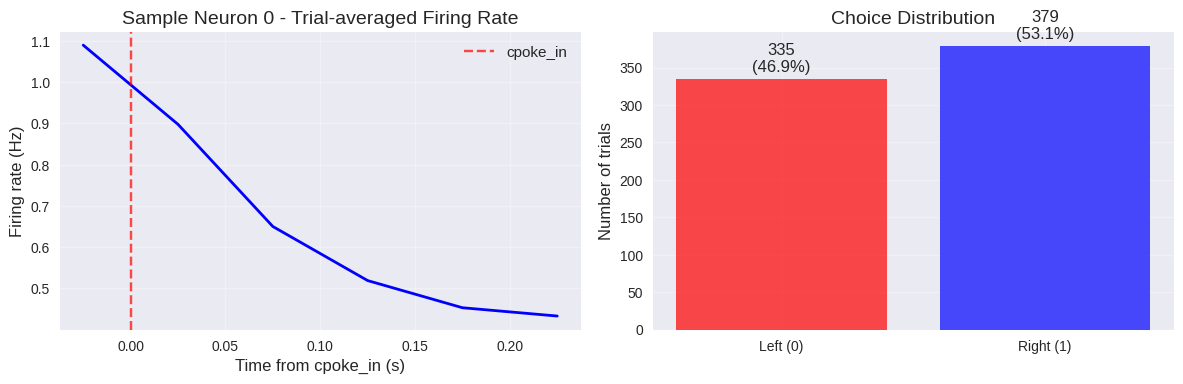


Ready to proceed to Section 4: Model Training & Cross-Validation


In [ ]:
# Update the function signatures defined in Section 1.3.4 with actual implementations

def calculate_firing_rates(spike_times: Dict[str, np.ndarray], 
                          trial_times: np.ndarray, 
                          time_bins: np.ndarray, 
                          sigma_ms: float = GAUSSIAN_SIGMA_MS) -> np.ndarray:
    """
    Calculate smoothed firing rates using Gaussian convolution.
    Implementation completed in Section 3.3
    """
    return calculate_firing_rates_gaussian(spike_times, trial_times, time_bins, sigma_ms)

# Verify data format is ready for sklearn logistic regression
print("Data preparation for logistic regression:")
print(f"  Neural data shape: {X.shape} (neurons, timepoints, trials)")
print(f"  Choices shape: {valid_choices.shape} (trials,)")
print(f"  Time bins shape: {time_bins.shape} (timepoints,)")

# Test data reshaping for sklearn (example for time point 0)
example_timepoint = 10  # Middle of analysis window
X_t_example = X[:, example_timepoint, :].T  # Shape: (trials, neurons)
print(f"  Example reshape for t={example_timepoint}: {X_t_example.shape} (trials, neurons)")

# Verify no missing data in critical variables
print(f"\nData completeness check:")
print(f"  X contains NaN: {np.any(np.isnan(X))}")
print(f"  valid_choices contains NaN: {np.any(np.isnan(valid_choices))}")
print(f"  time_bins contains NaN: {np.any(np.isnan(time_bins))}")

# Store key variables for next sections
preprocessing_results = {
    'X': X,  # Neural data (neurons, timepoints, trials)
    'choices': valid_choices,  # Binary choices (trials,)
    'time_bins': time_bins,  # Time bins for analysis
    'n_neurons': X.shape[0],
    'n_timepoints': X.shape[1], 
    'n_trials': X.shape[2],
    'filtered_spike_times': filtered_spike_times,
    'neuron_regions': filtered_regions,
    'neuron_hemispheres': filtered_hemispheres,
    'passes_qc': passes_qc
}

print(f"\nSection 3 Complete - Data Preprocessing Summary:")
print(f"  ✓ Extracted {preprocessing_results['n_neurons']} high-quality neurons")
print(f"  ✓ Processed {preprocessing_results['n_trials']} valid trials")
print(f"  ✓ Applied {GAUSSIAN_SIGMA_MS}ms Gaussian smoothing")
print(f"  ✓ Created {preprocessing_results['n_timepoints']} time points from {TIME_WINDOW[0]}s to {TIME_WINDOW[1]}s")
print(f"  ✓ Session quality control: {'PASSED' if passes_qc else 'FAILED'}")
print(f"  ✓ Data {'loaded from cache' if cache_valid else 'computed fresh and cached'}")

# Save preprocessing results to cache if computed fresh
if not cache_valid:
    print(f"\nSaving preprocessing results to cache...")
    
    # Prepare parameters for validation
    cache_parameters = {
        'GAUSSIAN_SIGMA_MS': GAUSSIAN_SIGMA_MS,
        'SAMPLING_INTERVAL_MS': SAMPLING_INTERVAL_MS,
        'TIME_WINDOW': TIME_WINDOW,
        'MIN_TRIALS': MIN_TRIALS,
        'MAX_LAPSE_RATE': MAX_LAPSE_RATE,
        'SESSION_ID': SESSION_ID,
        'SESSION_DATE': SESSION_DATE,
        'timestamp': pd.Timestamp.now().isoformat()
    }
    
    # Save all preprocessing results
    np.savez_compressed(
        str(CACHE_FILE),
        X=X,
        valid_choices=valid_choices,
        time_bins=time_bins,
        filtered_spike_times=filtered_spike_times,
        filtered_regions=np.array(filtered_regions),
        filtered_hemispheres=np.array(filtered_hemispheres),
        passes_qc=passes_qc,
        parameters=cache_parameters
    )
    
    print(f"✓ Cache saved to: {CACHE_FILE}")
    print(f"  File size: {CACHE_FILE.stat().st_size / 1024 / 1024:.1f} MB")

# Quick sanity check visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Average firing rate over time for a sample neuron
sample_neuron = 0
sample_fr = np.mean(X[sample_neuron, :, :], axis=1)  # Average across trials
axes[0].plot(time_bins, sample_fr, 'b-', linewidth=2)
axes[0].set_xlabel('Time from cpoke_in (s)')
axes[0].set_ylabel('Firing rate (Hz)')
axes[0].set_title(f'Sample Neuron {sample_neuron} - Trial-averaged Firing Rate')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(0, color='r', linestyle='--', alpha=0.7, label='cpoke_in')
axes[0].legend()

# Plot 2: Choice distribution
choice_counts = np.bincount(valid_choices)
axes[1].bar(['Left (0)', 'Right (1)'], choice_counts, color=['red', 'blue'], alpha=0.7)
axes[1].set_ylabel('Number of trials')
axes[1].set_title('Choice Distribution')
axes[1].grid(True, alpha=0.3)

# Add text annotations
for i, count in enumerate(choice_counts):
    axes[1].text(i, count + 5, f'{count}\n({count/len(valid_choices)*100:.1f}%)', 
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nReady to proceed to Section 4: Model Training & Cross-Validation")

# 4. Logistic Regression Model Training & Decision Variables Calculation

## 4.1 Cross-Validation Setup & Regularization Optimization

In [ ]:
# 4.1 Cross-Validation Setup & Regularization Optimization

def find_optimal_regularization(X, choices,
                                  log_space_search_min = -4,
                                  log_space_search_max = 2,
                                  log_space_search_n = 50,
                                  nan_threshold = NAN_THRESHOLD):
      """
      Find optimal regularization parameter using geometric mean approach from paper.
      
      Following methodology from decision_variables_methodology.md:
      1. 10-fold stratified cross-validation
      2. Find optimal λ for each time point independently  
      3. Calculate geometric mean of optimal λ values across all time points
      4. Use constant λ value for final models (crucial for temporal consistency)
      
      Parameters:
      - X: Neural data (n_neurons, n_timepoints, n_trials)
      - choices: Binary choices (n_trials,)
      
      Returns:
      - final_C: Optimal regularization parameter (C = 1/λ)
      - individual_lambdas: List of optimal λ values for each time point
      """
      n_neurons, n_timepoints, n_trials = X.shape
      optimal_lambdas = []
      convergence_warnings = []

      # Step 1: Find optimal λ for each time point
      cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_SEED)

      print(f"Finding optimal regularization across {n_timepoints} time points...")

      for t in tqdm(range(n_timepoints)):
          X_t = X[:, t, :].T  # Reshape to (trials, neurons)

          # Identify valid trials (no NaN values) following ANSWER notebook pattern
          valid_trials = ~np.isnan(X_t).any(axis=1)
          n_valid = np.sum(valid_trials)

          if n_valid < nan_threshold:  # Skip timepoints with too few valid trials
              print(f"Warning: Skipping time point {t} - only {n_valid} valid trials")
              optimal_lambdas.append(1.0)  # Use default lambda
              continue

          # Extract clean data (following ANSWER notebook NaN exclusion pattern)
          X_t_clean = X_t[valid_trials]
          choices_clean = choices[valid_trials]

          # Use LogisticRegressionCV to find optimal C (C = 1/λ) on clean data
          model = LogisticRegressionCV(
              Cs=np.logspace(log_space_search_min, log_space_search_max, log_space_search_n),  # Regularization range (C = 1/λ)
              cv=cv,
              penalty='l1',
              solver='liblinear', # seems appropriate for number of neurons
              scoring='balanced_accuracy',
              class_weight='balanced',
              max_iter=10000,
              random_state=RANDOM_SEED,
              n_jobs=-1, # Gotta love parallelization
              fit_intercept=True,
              intercept_scaling=100000,
          )

          with warnings.catch_warnings(record=True) as w:
              warnings.simplefilter("always")
              model.fit(X_t_clean, choices_clean)  # Use clean data

              # Check for convergence warnings
              conv_warnings = [warning for warning in w if issubclass(warning.category, ConvergenceWarning)]
              if conv_warnings:
                  print(f"Warning: Time point {t} did not converge (n_iter={model.n_iter_})")
                  convergence_warnings.append(t)
              # else:
              #     print(f"Time point {t}: Converged in {model.n_iter_} iterations")

          optimal_lambdas.append(1.0 / model.C_[0])  # Convert C back to λ

      # Step 2: Calculate geometric mean (critical step from paper)
      geometric_mean_lambda = np.exp(np.mean(np.log(optimal_lambdas)))
      final_C = 1.0 / geometric_mean_lambda

      print(f"Cross-validation completed:")
      print(f"  Individual λ range: {np.min(optimal_lambdas):.4f} - {np.max(optimal_lambdas):.4f}")
      print(f"  Geometric mean λ: {geometric_mean_lambda:.4f}")
      print(f"  Final C parameter: {final_C:.4f}")

      return final_C, optimal_lambdas



In [ ]:
# Execute cross-validation to find optimal regularization
print("=== Section 4.1: Cross-Validation & Regularization Optimization ===")
print(f"Data shape: {X.shape} (neurons, timepoints, trials)")
print(f"Choice distribution: {np.sum(valid_choices)} right, {len(valid_choices) - np.sum(valid_choices)} left")

final_C, individual_lambdas = find_optimal_regularization(X, valid_choices,
                                                          log_space_search_min=-7,
                                                          log_space_search_max=3,
                                                          log_space_search_n=50)

=== Section 4.1: Cross-Validation & Regularization Optimization ===
Data shape: (1, 22, 714) (neurons, timepoints, trials)
Choice distribution: 379 right, 335 left
Finding optimal regularization across 22 time points...


100%|██████████| 22/22 [00:01<00:00, 14.83it/s]

Cross-validation completed:
  Individual λ range: 1.8421 - 10000000.0000
  Geometric mean λ: 189.7987
  Final C parameter: 0.0053


## 4.2 Model Training & Decision Variables Extraction


In [ ]:
def calculate_decision_variables_cv_only(X, choices, final_C, cv_folds=10, nan_threshold=NAN_THRESHOLD):
    """
    Calculate decision variables using logistic regression models with NaN handling.
    
    Following methodology from decision_variables_methodology.md and ANSWER notebook NaN strategy:
    1. Fit separate logistic regression for each time point using constant regularization
    2. Exclude NaN timepoints/trials from sklearn operations using boolean masking
    3. Calculate decision variables as log-odds: DV(t,i) = X(t,i) · β(t) + α(t)
    4. Calculate prediction accuracy using balanced accuracy
    
    Parameters:
    - X: Neural data (n_neurons, n_timepoints, n_trials)
    - choices: Binary choices (n_trials,)
    - final_C: Regularization parameter from geometric mean
    
    Returns:
    - DVs: Decision variables (n_timepoints, n_trials)
    - models: Fitted models for each time point
    - accuracies: Prediction accuracy for each time point
    """
    n_neurons, n_timepoints, n_trials = X.shape
    DVs = np.zeros((n_timepoints, n_trials))
    test_accuracies = []
    models = []

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_SEED)

    for t in tqdm(range(n_timepoints)):
        X_t = X[:, t, :].T  # Shape: (trials, neurons)
        
        # Identify valid trials (no NaN values) following ANSWER notebook pattern
        valid_trials = ~np.isnan(X_t).any(axis=1)
        n_valid = np.sum(valid_trials)
        
        if n_valid < nan_threshold:  # Skip timepoints with too few valid trials
            print(f"Warning: Skipping time point {t} - only {n_valid} valid trials")
            DVs[t, :] = np.nan
            test_accuracies.append(np.nan)
            models.append(None)
            continue
        
        # Extract clean data (following ANSWER notebook NaN exclusion pattern)
        X_t_clean = X_t[valid_trials]
        choices_clean = choices[valid_trials]
        
        dv_predictions = np.full(n_trials, np.nan)  # Initialize with NaN

        # Only do cross-validation on clean data
        for train_idx, test_idx in cv.split(X_t_clean, choices_clean):
            X_train, X_test = X_t_clean[train_idx], X_t_clean[test_idx]
            y_train = choices_clean[train_idx]

            model = LogisticRegression(
                    C=final_C, 
                    penalty='l1',
                    solver='liblinear',
                    class_weight='balanced',
                    max_iter=10000,
                    random_state=RANDOM_SEED,
                    n_jobs=-1,
                    intercept_scaling=100000,
                    fit_intercept=True,
                )
            model.fit(X_train, y_train)

            # Manual DV calculation
            dv_test = X_test @ model.coef_.T + model.intercept_
            
            # Map back to original trial indices
            original_test_idx = np.where(valid_trials)[0][test_idx]
            dv_predictions[original_test_idx] = dv_test.flatten()

            models.append(model)

        DVs[t, :] = dv_predictions

        # Test accuracy from CV predictions on valid trials only
        valid_dv_predictions = dv_predictions[valid_trials]
        test_predictions = (valid_dv_predictions > 0).astype(int)
        test_acc = balanced_accuracy_score(choices_clean, test_predictions)
        test_accuracies.append(test_acc)

    return DVs, models, np.array(test_accuracies)

In [ ]:
print("=== Section 4.2: Model Training & Decision Variables Extraction ===")

DVs_2, models_2, accuracies_2 = calculate_decision_variables_cv_only(X, valid_choices, final_C)

=== Section 4.2: Model Training & Decision Variables Extraction ===


100%|██████████| 22/22 [00:00<00:00, 128.24it/s]


In [ ]:
for i, model in enumerate(models_2):
    if model.intercept_ != 0:
        print(f"Model {i} has a non-zero intercept: {model.intercept_[0]}")

Plotting 335 left trials, 379 right trials
Mean click onset time: 0.782771401960774


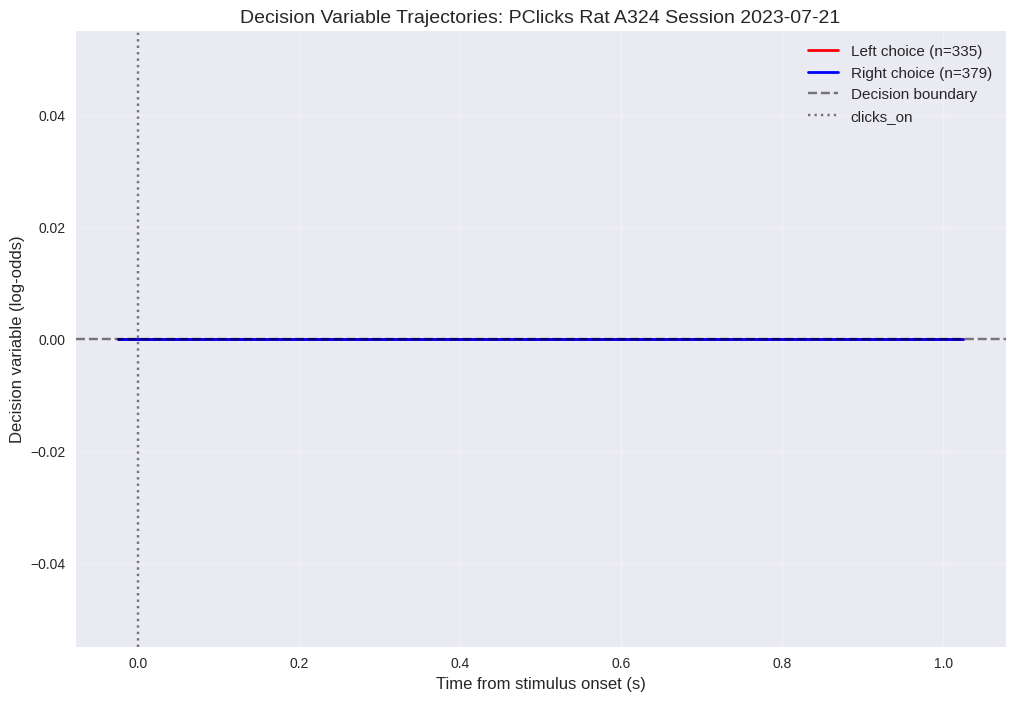

In [ ]:
def plot_dv_trajectories_manual(time_bins, DVs_2, valid_choices, region_name="Region"):
    """
    Plot average DV evolution for left vs right choices using manually calculated DVs
    
    Parameters:
    - time_bins: Time points relative to alignment event
    - DVs: Decision variables from calculate_decision_variables_manual (n_timepoints, n_trials)
    - choices: Binary choices (n_trials,) with 0=left, 1=right
    - region_name: Name for plot title
    """
    # Identify choice types

    left_trials = (valid_choices == 0)
    right_trials = (valid_choices == 1)
    # TODO: there has been a left/right switchup somewhere. This solution is a hack

    print(f"Plotting {np.sum(left_trials)} left trials, {np.sum(right_trials)} right trials")

    plt.figure(figsize=(12, 8))

    # Calculate mean and SEM for each choice type
    dv_left_mean = np.nanmean(DVs_2[:, left_trials], axis=1)
    dv_left_sem = np.nanstd(DVs_2[:, left_trials], axis=1) / np.sqrt(np.sum(left_trials))

    dv_right_mean = np.nanmean(DVs_2[:, right_trials], axis=1)
    dv_right_sem = np.nanstd(DVs_2[:, right_trials], axis=1) / np.sqrt(np.sum(right_trials))

    # Finding mean click onset time:

    mean_click_onset = np.mean(data["clicks_on"][valid_choices] - data["cpoke_in"][valid_choices])
    print(f"Mean click onset time: {mean_click_onset}")

    # Plot trajectories with error bars
    plt.plot(time_bins, dv_left_mean, 'r-', linewidth=2, label=f'Left choice (n={np.sum(left_trials)})')
    plt.fill_between(time_bins,
                    dv_left_mean - dv_left_sem,
                    dv_left_mean + dv_left_sem,
                    alpha=0.3, color='red')

    plt.plot(time_bins, dv_right_mean, 'b-', linewidth=2, label=f'Right choice (n={np.sum(right_trials)})')
    plt.fill_between(time_bins,
                    dv_right_mean - dv_right_sem,
                    dv_right_mean + dv_right_sem,
                    alpha=0.3, color='blue')

    # Add reference lines
    plt.axhline(0, color='k', linestyle='--', alpha=0.5, label='Decision boundary')
    plt.axvline(0, color='k', linestyle=':', alpha=0.5, label='First click')
    # plt.axvline(mean_click_onset, color='g', alpha=0.5, label='Mean click onset')


    # Formatting
    plt.xlabel('Time from stimulus onset (s)')
    plt.ylabel('Decision variable (log-odds)')
    plt.title(f'Decision Variable Trajectories: {region_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # # Add interpretation text
    # plt.text(0.02, 0.95, 'DV > 0: Evidence for right choice\nDV < 0: Evidence for left choice',
    #         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
    #         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    return plt.gcf()

  # Plot 1: Average trajectories by choice
fig1 = plot_dv_trajectories_manual(time_bins, DVs_2, valid_choices, f"PClicks Rat {SESSION_ID} Session {SESSION_DATE}")
plt.show()

# Section 5

Now that DVs are calculated correctly, I want to store the clicks and DVs data easily, ideally in dataframes so I can use them for glms after this

## 5.1: Defining Functions for Export

In [ ]:
def create_trial_dataframe(data, valid_trial_mask, max_trials):
    """
    Create trial-level DataFrame with behavioral summary data.
    
    Parameters:
    - data: Loaded .mat file data dictionary
    - valid_trial_mask: Boolean array indicating valid trials
    - max_trials: Maximum number of trials to process
    
    Returns:
    - pd.DataFrame with trial-level data
    """
    # Extract basic trial data
    n_total = min(max_trials, len(data['cpoke_in'].flatten()))
    trial_ids = np.arange(np.sum(valid_trial_mask))

    # Timing data (already filtered to valid trials)
    cpoke_in = data['cpoke_in'].flatten()[:n_total][valid_trial_mask]
    cpoke_out = data['cpoke_out'].flatten()[:n_total][valid_trial_mask]
    clicks_on = np.array([clicks[0] for clicks in data['clicks_on'][:n_total]])[valid_trial_mask]
    first_clicks = np.array(data['first_clicks']).flatten()[:n_total][valid_trial_mask]
    last_clicks = np.array(data['last_clicks']).flatten()[:n_total][valid_trial_mask]

    # Choice and outcome data
    choices = data['pokedR'].flatten()[:n_total][valid_trial_mask].astype(int)
    rewarded = data['is_hit'].flatten()[:n_total][valid_trial_mask].astype(bool)
    violated = data['violated'].flatten()[:n_total][valid_trial_mask].astype(bool)

    # Calculate click counts per trial
    left_bups = data['left_bups'][:n_total][valid_trial_mask]
    right_bups = data['right_bups'][:n_total][valid_trial_mask]

    n_left_clicks = [len(clicks[0]) if clicks[0].size > 0 else 0 for clicks in left_bups]
    n_right_clicks = [len(clicks[0]) if clicks[0].size > 0 else 0 for clicks in right_bups]
    total_clicks = np.array(n_left_clicks) + np.array(n_right_clicks)

    # Derived features
    trial_duration = cpoke_out - cpoke_in
    click_duration = last_clicks - first_clicks
    time_to_first_click = first_clicks - clicks_on
    decision_time = cpoke_out - last_clicks

    # Click rate during stimulus period
    click_rate = total_clicks / click_duration
    click_rate[click_duration == 0] = 0  # Handle zero-duration trials

    # Click asymmetry: (right - left) / (right + left)
    click_asymmetry = (np.array(n_right_clicks) - np.array(n_left_clicks)) / total_clicks
    click_asymmetry[total_clicks == 0] = 0  # Handle trials with no clicks

    return pd.DataFrame({
        'trial_id': trial_ids,
        'original_trial_num': np.where(valid_trial_mask)[0],
        'choice': choices,
        'rewarded': rewarded,
        'violated': violated,
        'cpoke_in': cpoke_in,
        'cpoke_out': cpoke_out,
        'clicks_on': clicks_on,
        'first_click': first_clicks,
        'last_click': last_clicks,
        'trial_duration': trial_duration,
        'click_duration': click_duration,
        'time_to_first_click': time_to_first_click,
        'decision_time': decision_time,
        'n_left_clicks': n_left_clicks,
        'n_right_clicks': n_right_clicks,
        'total_clicks': total_clicks,
        'click_rate': click_rate,
        'click_asymmetry': click_asymmetry
    })

In [ ]:
# Add this debugging code in the click DataFrame function
valid_trial_indices = np.where(valid_trial_mask)[0]

for trial_idx, original_trial in enumerate(valid_trial_indices[:3]):  # Just first 3 trials
    left_clicks = data['left_bups'][original_trial]
    right_clicks = data['right_bups'][original_trial]

    print(f"Trial {trial_idx}:")
    print(f"  left_clicks type: {type(left_clicks)}")
    print(f"  left_clicks shape: {left_clicks.shape if hasattr(left_clicks, 'shape') else 'no shape'}")
    print(f"  left_clicks[0] type: {type(left_clicks[0])}")
    print(f"  left_clicks[0] shape: {left_clicks[0].shape if hasattr(left_clicks[0], 'shape') else 'no shape'}")
    print(f"  left_clicks[0] contents: {left_clicks[0]}")

    if left_clicks[0].size > 0:
        print(f"  First click time type: {type(left_clicks[0][0])}")
        print(f"  First click time value: {left_clicks[0][0]}")
        print(f"  Is it an array? {isinstance(left_clicks[0][0], np.ndarray)}")
    print()

Trial 0:
  left_clicks type: <class 'numpy.ndarray'>
  left_clicks shape: (1,)
  left_clicks[0] type: <class 'numpy.ndarray'>
  left_clicks[0] shape: (1, 31)
  left_clicks[0] contents: [[0.00584  0.008845 0.026875 0.11402  0.117025 0.153085 0.219195 0.27629
  0.30634  0.321365 0.32437  0.42053  0.43856  0.48063  0.48664  0.525705
  0.54674  0.56477  0.651915 0.67295  0.687975 0.73906  0.748075 0.784135
  0.80517  0.808175 0.844235 0.904335 0.91335  0.934385 0.94941 ]]
  First click time type: <class 'numpy.ndarray'>
  First click time value: [0.00584  0.008845 0.026875 0.11402  0.117025 0.153085 0.219195 0.27629
 0.30634  0.321365 0.32437  0.42053  0.43856  0.48063  0.48664  0.525705
 0.54674  0.56477  0.651915 0.67295  0.687975 0.73906  0.748075 0.784135
 0.80517  0.808175 0.844235 0.904335 0.91335  0.934385 0.94941 ]
  Is it an array? True

Trial 1:
  left_clicks type: <class 'numpy.ndarray'>
  left_clicks shape: (1,)
  left_clicks[0] type: <class 'numpy.ndarray'>
  left_clicks[0] sh

In [ ]:
def create_click_dataframe(data, valid_trial_mask, max_trials):
    """
    Create click events DataFrame with one row per click.
    
    Parameters:
    - data: Loaded .mat file data dictionary  
    - valid_trial_mask: Boolean array indicating valid trials
    - max_trials: Maximum number of trials to process
    
    Returns:
    - pd.DataFrame with click event data
    """
    click_records = []
    valid_trial_indices = np.where(valid_trial_mask)[0]
    
    # Extract trial timing for context
    cpoke_in = data['cpoke_in'].flatten()[:max_trials][valid_trial_mask]
    cpoke_out = data['cpoke_out'].flatten()[:max_trials][valid_trial_mask]
    clicks_on = np.array([clicks[0] for clicks in data['clicks_on'][:max_trials]])[valid_trial_mask]
    first_clicks = np.array(data['first_clicks']).flatten()[:max_trials][valid_trial_mask]
    choices = data['pokedR'].flatten()[:max_trials][valid_trial_mask].astype(int)
    
    for trial_idx, original_trial in enumerate(valid_trial_indices):
        if original_trial >= max_trials:
            continue
            
        # Get clicks for this trial
        left_clicks = data['left_bups'][original_trial][0][0] # I hate matlab
        print(f"left_clicks.shape: {left_clicks}")
        right_clicks = np.ravel(data['right_bups'][original_trial])[0][0]
        print(f"right_clicks.shape: {right_clicks}")
        
        # Process left clicks
        if left_clicks.size > 0:
            left_times = left_clicks + clicks_on[trial_idx]  # Convert to absolute time
            for click_num, click_time in enumerate((left_times)):
                assert len(np.atleast_1d(click_time)) < 2, f"More than one click time detected {click_time}"
                click_records.append({
                    'trial_id': trial_idx,
                    'click_side': 'left',
                    'click_number': None,  # Will fill after processing both sides
                    'click_number_side': click_num + 1,
                    'click_time': float(click_time),
                    'time_from_clicks_on': float(click_time - clicks_on[trial_idx]),
                    'time_from_first_click': float(click_time - first_clicks[trial_idx]),
                    'time_from_cpoke_in': float(click_time - cpoke_in[trial_idx]),
                    'time_to_cpoke_out': float(cpoke_out[trial_idx] - click_time),
                    'choice': int(choices[trial_idx]),
                    'click_side_matches_choice': (choices[trial_idx] == 0)  # 0=left
                })
        
        # Process right clicks
        if right_clicks.size > 0:
            right_times = right_clicks + clicks_on[trial_idx]  # Convert to absolute time
            for click_num, click_time in enumerate(right_times):
                assert len(np.atleast_1d(click_time)) < 2, f"More than one click time detected {click_time}"
                click_records.append({
                    'trial_id': trial_idx,
                    'click_side': 'right',
                    'click_number': None,  # Will fill after processing both sides
                    'click_number_side': click_num + 1,
                    'click_time': float(click_time),
                    'time_from_clicks_on': float(click_time - clicks_on[trial_idx]),
                    'time_from_first_click': float(click_time - first_clicks[trial_idx]),
                    'time_from_cpoke_in': float(click_time - cpoke_in[trial_idx]),
                    'time_to_cpoke_out': float(cpoke_out[trial_idx] - click_time),
                    'choice': int(choices[trial_idx]),
                    'click_side_matches_choice': (choices[trial_idx] == 1)  # 1=right
                })
    
    # Convert to DataFrame
    click_df = pd.DataFrame(click_records)
    
    # Add overall click number (sorted by time within each trial)
    if len(click_df) > 0:
        click_df = click_df.sort_values(['trial_id', 'click_time'])
        click_df['click_number'] = click_df.groupby('trial_id').cumcount() + 1
        click_df = click_df.reset_index(drop=True)
    
    return click_df

In [ ]:
def create_dv_dataframe(DVs, valid_choices, time_bins, accuracies, trial_df):
    """
    Create decision variables DataFrame in long format.
    
    Parameters:
    - DVs: Decision variables array (n_timepoints, n_trials)
    - valid_choices: Binary choices array
    - time_bins: Time bin definitions
    - accuracies: Model accuracies per timepoint
    - trial_df: Trial DataFrame for additional context
    
    Returns:
    - pd.DataFrame with decision variable time series
    """
    n_timepoints, n_trials = DVs.shape
    
    # Create base arrays
    trial_ids = np.repeat(range(n_trials), n_timepoints)
    time_bin_indices = np.tile(range(n_timepoints), n_trials)
    time_bins_repeated = np.tile(time_bins, n_trials)
    dv_values = DVs.T.flatten()  # Transpose then flatten to get correct order
    choices_repeated = np.repeat(valid_choices, n_timepoints)
    
    # Calculate absolute times
    clicks_on_repeated = np.repeat(trial_df['clicks_on'].values, n_timepoints)
    time_absolute = clicks_on_repeated + time_bins_repeated
    
    # Calculate relative times to click events
    first_clicks_repeated = np.repeat(trial_df['first_click'].values, n_timepoints)
    last_clicks_repeated = np.repeat(trial_df['last_click'].values, n_timepoints)
    time_since_first_click = time_bins_repeated - (first_clicks_repeated - clicks_on_repeated)
    time_since_last_click = time_bins_repeated - (last_clicks_repeated - clicks_on_repeated)
    
    # Model accuracy (repeated for each trial at each timepoint)
    accuracy_repeated = np.tile(accuracies, n_trials)
    
    # Create DataFrame
    dv_df = pd.DataFrame({
        'trial_id': trial_ids,
        'time_bin_idx': time_bin_indices,
        'time_bin': time_bins_repeated,
        'time_absolute': time_absolute,
        'decision_variable': dv_values,
        'is_valid': ~np.isnan(dv_values),
        'model_accuracy': accuracy_repeated,
        'choice': choices_repeated,
        'rewarded': np.repeat(trial_df['rewarded'].values, n_timepoints),
        'time_since_first_click': time_since_first_click,
        'time_since_last_click': time_since_last_click
    })
    
    return dv_df

In [ ]:
def save_session_data(trial_df, click_df, dv_df, neural_data, metadata, filepath):
    """
    Save all DataFrames and arrays to HDF5 file.
    
    Parameters:
    - trial_df, click_df, dv_df: DataFrames to save
    - neural_data: Neural firing rates array
    - metadata: Dictionary with session metadata
    - filepath: Output HDF5 file path
    """
    with pd.HDFStore(filepath, mode='w') as store:
        # Save DataFrames
        store.put('trials', trial_df, format='table')
        store.put('clicks', click_df, format='table')  
        store.put('decision_variables', dv_df, format='table')
        
        # Save neural data as array
        store.put('neural_data', pd.DataFrame(neural_data.reshape(neural_data.shape[0], -1)))
        
        # Save metadata
        metadata_for_hdf = metadata.copy()
        metadata_for_hdf['analysis_params'] = json.dumps(metadata['analysis_params'])
        metadata_for_hdf['data_shapes'] = json.dumps(metadata['data_shapes'])
        metadata_df = pd.DataFrame([metadata_for_hdf]) 
        store.put('metadata', metadata_df, format='table')
        
        # Store neural data shape separately for reconstruction
        shape_df = pd.DataFrame([{'shape': neural_data.shape}])
        store.put('neural_data_shape', shape_df)

def load_session_data(filepath):
    """
    Load all data from HDF5 file.
    
    Parameters:
    - filepath: HDF5 file path
    
    Returns:
    - Dictionary with all loaded data
    """
    with pd.HDFStore(filepath, mode='r') as store:
        trial_df = store.get('trials')
        click_df = store.get('clicks')
        dv_df = store.get('decision_variables')
        
        # Reconstruct neural data
        neural_flat = store.get('neural_data').values
        neural_shape = store.get('neural_data_shape')['shape'].iloc[0]
        neural_data = neural_flat.reshape(neural_shape)
        
        # Load metadata and parse JSON
        metadata_df = store.get('metadata')
        metadata = metadata_df.iloc[0].to_dict()

        # Parse the JSON string back to dictionary
        if 'analysis_params' in metadata and isinstance(metadata['analysis_params'], str):
            metadata['analysis_params'] = json.loads(metadata['analysis_params'])
        if 'data_shapes' in metadata and isinstance(metadata['data_shapes'], str):
            metadata['data_shapes'] = json.loads(metadata['data_shapes'])

    return {
        'trial_df': trial_df,
        'click_df': click_df, 
        'dv_df': dv_df,
        'neural_data': neural_data,
        'metadata': metadata
    }

## 5.2: Creating Dataframes

In [ ]:
print("Creating structured DataFrames for analysis...")

# Create trial-level DataFrame
trial_df = create_trial_dataframe(data, valid_trial_mask, max_trials=data["nTrials"][0][0])
print(f"✓ Trial DataFrame: {len(trial_df)} trials × {len(trial_df.columns)} columns")

# Display trial DataFrame summary
print(f"\nTrial DataFrame Summary:")
print(f"  Columns: {list(trial_df.columns)}")
print(f"  Data types: {trial_df.dtypes.value_counts().to_dict()}")
print(f"  Choice distribution: {trial_df['choice'].value_counts().to_dict()}")
print(f"  Rewarded trials: {trial_df['rewarded'].sum()} ({trial_df['rewarded'].mean()*100:.1f}%)")
print(f"  Mean trial duration: {trial_df['trial_duration'].mean():.2f}s")
print(f"  Mean total clicks per trial: {trial_df['total_clicks'].mean():.1f}")

print(trial_df.head())

Creating structured DataFrames for analysis...
✓ Trial DataFrame: 714 trials × 19 columns

Trial DataFrame Summary:
  Columns: ['trial_id', 'original_trial_num', 'choice', 'rewarded', 'violated', 'cpoke_in', 'cpoke_out', 'clicks_on', 'first_click', 'last_click', 'trial_duration', 'click_duration', 'time_to_first_click', 'decision_time', 'n_left_clicks', 'n_right_clicks', 'total_clicks', 'click_rate', 'click_asymmetry']
  Data types: {dtype('float64'): 11, dtype('int64'): 6, dtype('bool'): 2}
  Choice distribution: {1: 379, 0: 335}
  Rewarded trials: 600 (84.0%)
  Mean trial duration: 1.71s
  Mean total clicks per trial: 2.0
   trial_id  original_trial_num  choice  rewarded  violated     cpoke_in  \
0         0                   1       0      True     False  1669.169780   
1         1                   2       1      True     False  1679.663784   
2         2                   3       1      True     False  1689.026782   
3         3                   4       1      True     False  169

In [ ]:
# Create click events DataFrame  
click_df = create_click_dataframe(data, valid_trial_mask, max_trials=data["nTrials"][0][0])
print(f"✓ Click DataFrame: {len(click_df)} clicks × {len(click_df.columns)} columns")

# Display click DataFrame summary
print(f"\nClick DataFrame Summary:")
print(f"  Columns: {list(click_df.columns)}")
print(f"  Click side distribution: {click_df['click_side'].value_counts().to_dict()}")
print(f"  Clicks per trial range: {click_df.groupby('trial_id').size().min()} - {click_df.groupby('trial_id').size().max()}")
print(f"  Mean time from clicks_on: {click_df['time_from_clicks_on'].mean():.3f}s")
print(f"  Choice accuracy: {click_df['click_side_matches_choice'].mean()*100:.1f}% of clicks match final choice")

print(click_df.head(10))

left_clicks.shape: [0.00584  0.008845 0.026875 0.11402  0.117025 0.153085 0.219195 0.27629
 0.30634  0.321365 0.32437  0.42053  0.43856  0.48063  0.48664  0.525705
 0.54674  0.56477  0.651915 0.67295  0.687975 0.73906  0.748075 0.784135
 0.80517  0.808175 0.844235 0.904335 0.91335  0.934385 0.94941 ]
right_clicks.shape: [0.00584  0.02988  0.13806  0.153085 0.34841  0.42654  0.928375]
left_clicks.shape: [0.03278]
right_clicks.shape: [0.03278  0.035785 0.149975 0.198055 0.228105 0.246135 0.294215 0.318255
 0.330275 0.35131 ]
left_clicks.shape: [0.03578]
right_clicks.shape: [0.03578  0.050805 0.06583  0.08987  0.110905 0.183025 0.225095 0.231105
 0.261155 0.273175 0.2882  ]
left_clicks.shape: [0.08335  0.128425 0.13744  0.18552  0.22158  0.25163  0.35981  0.422915
 0.44996 ]
right_clicks.shape: [0.08335  0.128425 0.194535 0.254635 0.2937   0.344785 0.38385  0.41991
 0.434935 0.46198  0.50405  0.555135 0.57016 ]
left_clicks.shape: [0.005785 0.12899  0.156035 0.27323  0.29126  0.33934  0.34

In [ ]:
# Create decision variables DataFrame
dv_df = create_dv_dataframe(DVs_2, valid_choices, time_bins, accuracies_2, trial_df)
print(f"✓ DV DataFrame: {len(dv_df)} timepoints × {len(dv_df.columns)} columns")

# Display decision variables DataFrame summary
print(f"\nDecision Variables DataFrame Summary:")
print(f"  Columns: {list(dv_df.columns)}")
print(f"  Total timepoints: {len(dv_df)} ({dv_df['trial_id'].nunique()} trials × {dv_df['time_bin_idx'].nunique()} time bins)")
print(f"  Valid DV values: {dv_df['is_valid'].sum()} ({dv_df['is_valid'].mean()*100:.1f}%)")
print(f"  DV range: {dv_df['decision_variable'].min():.3f} to {dv_df['decision_variable'].max():.3f}")
print(f"  Mean model accuracy: {dv_df['model_accuracy'].mean():.3f}")

print(dv_df.head(10))

✓ DV DataFrame: 15708 timepoints × 11 columns

Decision Variables DataFrame Summary:
  Columns: ['trial_id', 'time_bin_idx', 'time_bin', 'time_absolute', 'decision_variable', 'is_valid', 'model_accuracy', 'choice', 'rewarded', 'time_since_first_click', 'time_since_last_click']
  Total timepoints: 15708 (714 trials × 22 time bins)
  Valid DV values: 12079 (76.9%)
  DV range: 0.000 to 0.000
  Mean model accuracy: 0.500
   trial_id  time_bin_idx  time_bin  time_absolute  decision_variable  \
0         0             0    -0.025    1669.684279                0.0   
1         0             1     0.025    1669.734279                0.0   
2         0             2     0.075    1669.784279                0.0   
3         0             3     0.125    1669.834279                0.0   
4         0             4     0.175    1669.884279                0.0   
5         0             5     0.225    1669.934279                0.0   
6         0             6     0.275    1669.984279                0.

## 5.3 Data Validation

Optional checks - will comments this out for now

In [ ]:
def validate_data_structure(trial_df, click_df, dv_df, neural_data, original_data):
    """
    Comprehensive validation of created data structures.
    """
    checks_passed = 0
    total_checks = 0
    
    print("Running comprehensive data structure validation...")
    
    # 1. Basic structure checks
    total_checks += 1
    if len(trial_df.columns) >= 15:  # Expected minimum columns
        checks_passed += 1
        print("✓ Trial DataFrame has expected columns")
    else:
        print("✗ Trial DataFrame missing columns")
    
    # 2. Data completeness
    total_checks += 1
    if not trial_df.isnull().any().any():
        checks_passed += 1
        print("✓ No missing values in trial data")
    else:
        print("✗ Missing values found in trial data")
        print(f"  Missing values: {trial_df.isnull().sum().sum()}")
    
    # 3. Referential integrity
    total_checks += 1
    if click_df['trial_id'].isin(trial_df['trial_id']).all():
        checks_passed += 1
        print("✓ All click events link to valid trials")
    else:
        print("✗ Orphaned click events found")
    
    total_checks += 1
    if dv_df['trial_id'].isin(trial_df['trial_id']).all():
        checks_passed += 1
        print("✓ All DV records link to valid trials")
    else:
        print("✗ Orphaned DV records found")
    
    # 4. Data consistency
    total_checks += 1
    expected_dv_rows = len(trial_df) * len(time_bins)
    if len(dv_df) == expected_dv_rows:
        checks_passed += 1
        print("✓ DV DataFrame has expected number of rows")
    else:
        print(f"✗ DV DataFrame size mismatch: got {len(dv_df)}, expected {expected_dv_rows}")
    
    # 5. Value ranges
    total_checks += 1
    if trial_df['choice'].isin([0, 1]).all():
        checks_passed += 1
        print("✓ All choices are binary (0/1)")
    else:
        print("✗ Invalid choice values found")
    
    # 6. Click timing consistency
    total_checks += 1
    if (click_df['time_from_clicks_on'] >= 0).all():
        checks_passed += 1
        print("✓ All click times are after clicks_on")
    else:
        print("✗ Some clicks occur before clicks_on")
    
    # 7. Neural data alignment
    total_checks += 1
    if neural_data.shape[2] == len(trial_df):
        checks_passed += 1
        print("✓ Neural data trial count matches trial DataFrame")
    else:
        print(f"✗ Neural data trial count mismatch: {neural_data.shape[2]} vs {len(trial_df)}")
    
    # 8. Time bins alignment  
    total_checks += 1
    if dv_df['time_bin_idx'].nunique() == len(time_bins):
        checks_passed += 1
        print("✓ DV time bins match analysis time bins")
    else:
        print(f"✗ DV time bins mismatch: {dv_df['time_bin_idx'].nunique()} vs {len(time_bins)}")
    
    print(f"\nValidation Summary: {checks_passed}/{total_checks} checks passed")
    return checks_passed == total_checks

# # Run validation
# validation_passed = validate_data_structure(trial_df, click_df, dv_df, X, data)

# # Display summary statistics
# print(f"\nData Structure Summary:")
# print(f"  Trials: {len(trial_df)}")
# print(f"  Total clicks: {len(click_df)}")
# print(f"  DV timepoints: {len(dv_df)}")
# print(f"  Neural data shape: {X.shape}")
# print(f"  Validation status: {'PASSED' if validation_passed else 'FAILED'}")

## 5.4 Export to HDF5

In [ ]:
# Prepare metadata for session
session_metadata = {
    'session_id': SESSION_ID,
    'session_date': SESSION_DATE,
    'n_trials': len(trial_df),
    'n_neurons': X.shape[0],
    'n_timepoints': len(time_bins),
    'analysis_params': {
        'gaussian_sigma_ms': GAUSSIAN_SIGMA_MS,
        'time_window': TIME_WINDOW,
        'cv_folds': CV_FOLDS,
        'regularization_C': final_C
    },
    'data_shapes': {
        'neural_data': X.shape,
        'decision_variables': DVs_2.shape,
        'trial_df': trial_df.shape,
        'click_df': click_df.shape,
        'dv_df': dv_df.shape
    },
    'validation_passed': False,
    'creation_timestamp': pd.Timestamp.now().isoformat(),
    'notebook_version': 'decision_variables_extraction_v003'
}

# Define output file path
output_file = OUTPUT_DIR / f"{SESSION_ID}/{SESSION_DATE}/{SESSION_ID}_{SESSION_DATE}_session_data.h5"
print(f"Saving structured data to: {output_file}")

# Save structured data  
save_session_data(trial_df, click_df, dv_df, X, session_metadata, output_file)
print(f"✓ Session data saved successfully")
print(f"  File size: {output_file.stat().st_size / 1024 / 1024:.1f} MB")

Saving structured data to: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/processed/A324/2023-07-21/A324_2023-07-21_session_data.h5
✓ Session data saved successfully
  File size: 4.5 MB


/tmp/ipykernel_394810/3049447503.py:29: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['shape'], dtype='object')]

  store.put('neural_data_shape', shape_df)


## 5.5 Validate Save/Load Cycle

In [ ]:
# Test save/load cycle to verify data integrity
print("Testing save/load cycle...")
loaded_data = load_session_data(output_file)

# Verify loaded data matches original
print("Verifying loaded data integrity:")

# Check DataFrames
print(f"✓ Trial DataFrame: {loaded_data['trial_df'].shape == trial_df.shape}")
print(f"✓ Click DataFrame: {loaded_data['click_df'].shape == click_df.shape}")
print(f"✓ DV DataFrame: {loaded_data['dv_df'].shape == dv_df.shape}")

# Check neural data
print(f"✓ Neural data shape: {loaded_data['neural_data'].shape == X.shape}")
print(f"✓ Neural data values match: {np.allclose(loaded_data['neural_data'], X, equal_nan=True)}")

# Check metadata
print(f"✓ Metadata loaded: {loaded_data['metadata']['session_id'] == SESSION_ID}")

print(f"\n✓ Save/load cycle validation: PASSED")

# Display final summary
print(f"\n" + "="*60)
print("CLICKDV DATA STRUCTURE IMPLEMENTATION COMPLETE")
print("="*60)
print(f"Session: {SESSION_ID} ({SESSION_DATE})")
print(f"Output file: {output_file}")
print(f"File size: {output_file.stat().st_size / 1024 / 1024:.1f} MB")
print()
print("Data structures created:")
print(f"  • Trial DataFrame: {trial_df.shape[0]} trials × {trial_df.shape[1]} features")
print(f"  • Click DataFrame: {click_df.shape[0]} clicks × {click_df.shape[1]} features")  
print(f"  • Decision Variables DataFrame: {dv_df.shape[0]} timepoints × {dv_df.shape[1]} features")
print(f"  • Neural data: {X.shape} (neurons × timepoints × trials)")
print()
print("Ready for downstream analysis!")
print("="*60)

Testing save/load cycle...
Verifying loaded data integrity:
✓ Trial DataFrame: True
✓ Click DataFrame: True
✓ DV DataFrame: True
✓ Neural data shape: True
✓ Neural data values match: True
✓ Metadata loaded: True

✓ Save/load cycle validation: PASSED

CLICKDV DATA STRUCTURE IMPLEMENTATION COMPLETE
Session: A324 (2023-07-21)
Output file: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/processed/A324/2023-07-21/A324_2023-07-21_session_data.h5
File size: 4.5 MB

Data structures created:
  • Trial DataFrame: 714 trials × 19 features
  • Click DataFrame: 18664 clicks × 11 features
  • Decision Variables DataFrame: 15708 timepoints × 11 features
  • Neural data: (1, 22, 714) (neurons × timepoints × trials)

Ready for downstream analysis!
